# Chapter 6. Decision Trees
> These are the classic, and most intuitive structures in machine learning. Where thresholds are developed on features, and these lead to further decision points on subsequent features, leading to a classification. These can be loosely used for regression too! One of the great benefits is a simple explanation of the algorithm's conclusions.

- In this Chapter, we will start by discussing how to train, validate, and make predictions with decision trees.
- Then we will go through the CART training algorithm used by Scikit-Learn, we will discuss how to regularize trees and use them in regression tasks.
- Finally, we will discuss some of the limitations of decision trees.

## Training & Visualizing a Decision Tree

- To understand decision trees, let's start by building one and taking a look at its predictions.

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [4]:
iris = load_iris()
X = iris.data[:,2:]
y = iris.target
X.shape, y.shape

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

- You can visualize the decision tree by using the `export_graphiz()` method to export a graph representation file then taking a look at it:

In [11]:
from sklearn.tree import export_graphviz
export_graphviz(tree_clf, 
                out_file='iris_tree.dot', 
                feature_names=iris.feature_names[2:],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

In [12]:
! dot -Tpng models/06/iris_tree.dot -o static/imgs/iris_tree.png

/bin/sh: dot: command not found


## Making Predictions

- To classify a new data point, you start at the root node of the graph (on the top), and you answer the binary questions and you reach the end leaf.
    - That end leaf represents your class.
        - It's really that simple!
- One of the many qualities of decision trees is that they require very little data preparation.
    - **In fact, they don't require feature scaling or centering at all!**
- A node's `samples` attribute counts how many training instances are sitting on the node.
- A node's `value` attribute tells you have many instances of each class are setting on the node.
- A node's `gini` attribute measures the nodes impurity (pure == 0)
    - The following equation shows how the training algorithm computes the gini scores of the ith node:

        $$G_i=1-\sum_{k=1}^n{p_{i,k}}^2$$

    - Where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in that particular node.
        - In our case: $k \in \{1,2,3\}$.
- Scikit-learn uses the CART algorithm, which produces only binary trees
    - Non-leaf nodes only have two children
- However, other algorithms such as ID3 can produce decision trees with nodes that have more than 2 children.
- The following figure shows the decision boundaries of our decision tree
    - Decision Trees tend to create lines/rectangles/boxes/.. and split the feature space linearly but iteratively.
 
<div style="text-align:center"><img style="width:50%" src="static/imgs/decision_tree_boundaries.png"></div>

- Decision Trees are intuitive, and their predictions are easily interpretable.
    - These types of models are called **white box** models.
- In contrast, as we will see, Random Forests and Neural Networks are generally considered Black Box models.

## Estimating Class Probabilities

- A decision tree can also estimate the probability that a certain instance belongs to a certain class.
    - It just returns the ratio of that class over the sum of all instances in the leaf.
- Let's check this in scikit-learn:

In [13]:
tree_clf.predict_proba([[5, 1.5]])
tree_clf.predict([[5, 1.5]])

array([1])

- Interesting insight: you'll get the same probability as long as you're in a certain leaf box
    - It doesn't matter if your new data point gets closer to the decision boundaries.

## The CART Training Algorithm

- Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train decision trees (also called "growing" trees).
- The algorithm works by first splitting the training set by feature $k$ and threshold $t_k$.
- How does it choose $k$ and $t_k$?
    - It searches for $(k,t_k)$ that produce the purest subsets.
        - Weighted by their size.
- The following gives the loss function that CART tries to minimize:

$$J(k,t_k)=\frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$$

- Where:
    - $G_{left/right}$ measures the resulted impurity in the left/right subsets.
    - $m_{left/right}$ correspond to the number of instances in the left/right subsets.
- Once the CART algorithm successfully split the initial training data into two subsets, it does the same thing to both subsets.
- It stops recursing once it reaches the maximum allowed tree depth (the `max_depth` hyper-parameter).
    - Or if it cannot find a split that reduces impurity.
- A few other hyper-parameters control stopping like:
    - `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_leaf_nodes`.
- The CART algorithm is greedy in the sense that it doesn't care if its current split will lead to an optimal downstream leaf.
    - It only cares about finding the best possible split at the current leaf.
    - In that sense, it doesn't necessarily result in an optimal solution.
- Unfortunately, finding the optimal tree is known to be an **NP-Complete** problem with a complexity of $O(exp(m))$.

## Computational Complexity

- Making a prediction requires us to go from the root the final leaf.
- Decision trees are approximately balanced, so traversing the decision tree require going through roughly $O(log_{2}(m))$.
- Since each node requires check the value of only one feature, the overall inference running time is $O(log_{2}(m))$.
    - Independent of the number of features.
        - So predictions are really fast, even when dealing with a large number of features.
- The training algorithm compares all features (except if `max_features` is set) on all samples at each node.
- Comparing all features at all samples at each node results in a training complexity of $O(n \times mlog_2(m))$.
    - For small training sets (less than a few thousands), scikit-learn can speed up training by presorting the data.

## Gini Impurity or Entropy?

- In information theory, entropy is zero when all messages are identical.
- In ML, entropy is often used as an impurity measure.
- A set's entropy is zero when **it contains instances of only one class**.
- The following formula shows the entropy at node $i$:

$$H_i=-\sum_{k=1}^{n}p_{i,k}log_2(p_{i,k})$$

- There's no big difference between using Gini or Entropy to measure impurity.
    - Gini impurity is slightly faster to compute.
    - When they differ, Entropy tends to produce more balanced trees.

## Regularization Hyperparameters

- **Decision Trees make very few assumptions about the training data**.
- If left unconstrained and because of its flexibility, a decision tree will adapt itself to perfectly fit the training data.
    - Naturally leading to overfitting.
- Such a model is often called a *non-parameteric model* because the number of parameters is not determined before training.
- You can at least restrict the maximum depth of the decision tree.
- Other regularization hyper-parameters include:
    - `min_samples_split`: The minimum number of samples a node must have for it to split.
    - `min_samples_leaf`: The minimum number of samples a leaf must have.
    - `min_weight_fraction_leaf`: `mean_samples_leaf` as a fraction.
    - `max_leaf_nodes`: the maximum number of leaf nodes.
    - `max_features`: The maximum number of features that are evaluated for any split.
- The following figure shows two decision trees trained on the same moon dataset, the left one represent an unconstrained trained decision tree, and the right one is regularized using the `min_samples_leaf` hyper-parameter:

<div style="text-align:center"><img style="width:50%" src="static/imgs/regularized_tree.png"></div>

```
For instance, if min_samples_split = 5, and there are 7 samples at an internal node, then the split is allowed. But let's say the split results in two leaves, one with 1 sample, and another with 6 samples. If min_samples_leaf = 2, then the split won't be allowed (even if the internal node has 7 samples) because one of the leaves resulted will have less then the minimum number of samples required to be at a leaf node.
```

## Regression

- Decision Trees are also capable of performing regression tasks.
- Let's try it using scikit-learn:
- First we want to generate a noisy quadratic dataset:

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

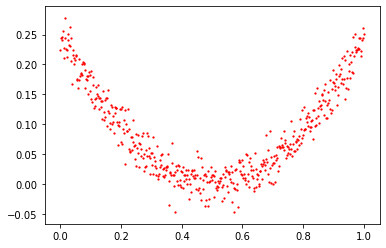

In [15]:
X = np.linspace(start=0, stop=1, num=500)
y = (X-0.5)**2 + np.random.randn(500)/50.

plt.scatter(X, y, s=1.5, c='red')

In [16]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X[..., None], y[..., None])

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [18]:
export_graphviz(tree_reg, 
                out_file='reg_tree.dot', 
                feature_names=['X'],
                class_names=['y'],
                rounded=True,
                filled=True)

<div style="text-align:center"><img style="width:50%" src="static/imgs/reg_tree.png"></div>

- This tree looks very similar to the classification tree we built earlier.
- The main difference is that instead of predicting a class for each node, it predicts a value.
- the prediction represents the average target value for the group in the leaf.
- As you increase the `max_depth` hyper-parameter, you provide the regression tree with more flexibility, the following showcases tree predictions in red:

<div style="text-align:center"><img style="width:66%" src="static/imgs/regression_trees.png"></div>

- The CART algorithm works almost the same as before, but instead of searching for a split that minimizes impurity, it searches for a split that produce balanced samples per leaf and minimize $MSE$.
- We show the cost function that the algorithm tries to minimize:

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} \\ MSE=\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{i}-y_{i})^{2}$$

- Just like classification, regression trees are prone to overfitting the training data, without any regularization, we endup with the plot on the left, and setting `min_samples_leaf=10` produce a much reasonable model:

<div style="text-align:center"><img style="width:66%" src="static/imgs/regularizing_trees.png"></div>

## Instability

- Decision Trees have a few limitations:
    - Decision Trees love orthogonal decision boundaries.
        - Which makes them sensitive to training set rotation.
            - One way to limit this problem is to use PCA (Principal Component Analysis) which often results in a better orientation of the training data.
    - Decision Trees are sensitive to small variations in the training data.
        - In fact, because scikit-learn uses stochastic optimization, you might get different models for the same training dataset.
            - Random Forests can solve this problem by averaging incoming prediction from many decision trees.
---